In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import os
import sys
import glob
import time
import pytz
import datetime as dt
import dateutil
from itertools import chain
from cycler import cycler
from io import StringIO

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvlib as pvlib
import sklearn as sc

ONE_DAY = dt.timedelta(days=1)

In [56]:
# Style of figures
plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = 15, 6.5
# get colormap
#cmap=plt.cm.hsv
cmap =  plt.cm.gist_ncar
#cmap=plt.cm.brg
# build cycler with 10 equally spaced colors from that colormap
c = cycler('color', cmap(np.linspace(0,1,17)) )
# supply cycler to the rcParam
plt.rcParams["axes.prop_cycle"] = c

In [57]:
#function to find all files 
def find_files(date_1, date_2, mask, bdd_dir):

    tmp_date = date_1
    list_files = []
    while tmp_date <= date_2:
        
        in_dir = bdd_dir.format(tmp_date)
        tmp_file = mask.format(tmp_date)
        tmp_file = os.path.join(in_dir, tmp_file)
        #print(tmp_file)
        tmp_list = sorted(glob.glob(tmp_file))
        #print(tmp_list)
    
        if len(tmp_list) != 0:
            list_files.append(tmp_list)
        
        tmp_date += ONE_DAY
    
    return sorted([file_ for file_ in chain.from_iterable(list_files)])



In [58]:
## PV Modules DrahiX 

## Tilt = 30º, Orientation = 2ºW

    # 46,48,49,51 LONGI LR6-60PE-310M(reflector plane in face)
    # 45,47,50,52 LONGI LR6-60HPH-320M (reflector plane in face)

    # 42,43 LONGI LR6-60PE-310M
    # 41,44 LONGI LR6-60HPH-320M

## Tilt = 20º, Orientation = 2ºW

    # 33-40 LONGI_LR6-60BP_305W
    # 26,28,29,32 LONGI LR6-60HPH-320M 
    # 25,27,29,31 LONGI LR6-60PE-310M
    # 17-24  QCELLS Q.PEAK DUO-G6 345
    #  9-16  VMH 300-6-60-MW (white)
    #  1- 8  VMH 300-6-60-MB (black)




In [59]:
Wp = [300]*8 + [300]*8 + [345]*8 + [310,320]*4 + \
     [305]*8 + [320,310,310,320] + \
     [320,310]*2 + [310,320]*2

S = [1.633]*16 + [1.74*1.03]*8 + [1.65*0.991,1.683*0.996]*4 + \
    [1.664*0.996]*8 + [1.683*0.996,1.65*0.991,1.65*0.991,1.683*0.996] + \
    [1.683*0.996,1.65*0.991]*2 + [1.65*0.991,1.683*0.996]*2

## Creating a list of file names

In [60]:
folder=''
#filename='Real_Time_Saving_{:%Y-%m-%d}*.txt'
filename='PV_DrahiX_modules_Meteo_SIRTA_20200801_20211231.csv'
#filename='/Users/jbadosa/Downloads/Drahi*.csv'


files=glob.glob(filename)
print(files)



['PV_DrahiX_modules_Meteo_SIRTA_20200801_20211231.csv']


## Read the Data

In [61]:
data = []
data = pd.read_csv(
    filename, # nom du fichier
    sep=',',  # le caractère utilisé comme séparateur de colonne
    header=0,  # la ligne contenant le titre des colonnes
    infer_datetime_format=True,  # on le laisse tenter de décoder les dates seules
    parse_dates=['datetime'],  # on indique les colonnes contenant des dates
    index_col=['datetime'],  # la colonne jouant le role "d'index", la colonne principale
)

In [62]:
data.tail(4)

,AirTemp,Diffuse_Solar_Flux,Direct_Solar_Flux,Downwelling_IR_Flux,GHI_TOA,GHI_clear,Global_Solar_Flux,P01,P02,P03,...,SAA,SZA,Tp,Tp_sandia,doy,pres,rain,rh,wd,ws
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-02 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
data.columns

Index(['AirTemp', 'Diffuse_Solar_Flux', 'Direct_Solar_Flux',
       'Downwelling_IR_Flux', 'GHI_TOA', 'GHI_clear', 'Global_Solar_Flux',
       'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50',
       'P51', 'P52', 'P53', 'PAC', 'PDC', 'POA', 'POAc20', 'POAc30', 'SAA',
       'SZA', 'Tp', 'Tp_sandia', 'doy', 'pres', 'rain', 'rh', 'wd', 'ws'],
      dtype='object')

## Modelling POA_Global using sky diffuse irradiance model

In [64]:
Model_POA_data = data[["Diffuse_Solar_Flux", "Direct_Solar_Flux","SAA","SZA"]]
Model_POA_data

,Diffuse_Solar_Flux,Direct_Solar_Flux,SAA,SZA
datetime,,,,
2020-08-01 00:00:00+00:00,-1.077,-0.377,-177.411,90.0
2020-08-01 00:15:00+00:00,-1.173,-0.450,-173.536,90.0
2020-08-01 00:30:00+00:00,-1.173,-0.471,-169.682,90.0
2020-08-01 00:45:00+00:00,-1.170,-0.428,-165.862,90.0
2020-08-01 01:00:00+00:00,-1.173,-0.419,-162.088,90.0
...,...,...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN,NaN,NaN


In [65]:
air_mass = pvlib.atmosphere.get_relative_airmass(data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = data.index.dayofyear

data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=data.SZA,solar_azimuth=data.SAA,
                                         dni=data.Direct_Solar_Flux,
                                         ghi=data.Global_Solar_Flux,
                                         dhi=data.Diffuse_Solar_Flux,
                                         dni_extra=data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='klucher')
data['POAc20']=total_irrads.poa_global
total_irrads.poa_global

datetime
2020-08-01 00:00:00+00:00   -0.918050
2020-08-01 00:15:00+00:00   -0.986224
2020-08-01 00:30:00+00:00   -0.979973
2020-08-01 00:45:00+00:00   -0.994944
2020-08-01 01:00:00+00:00   -1.003628
                               ...   
2022-01-02 20:45:00+00:00         NaN
2022-01-02 21:00:00+00:00         NaN
2022-01-02 21:15:00+00:00         NaN
2022-01-02 21:30:00+00:00         NaN
2022-01-02 21:45:00+00:00         NaN
Name: poa_global, Length: 49912, dtype: float64

(0.0, 1300.0)

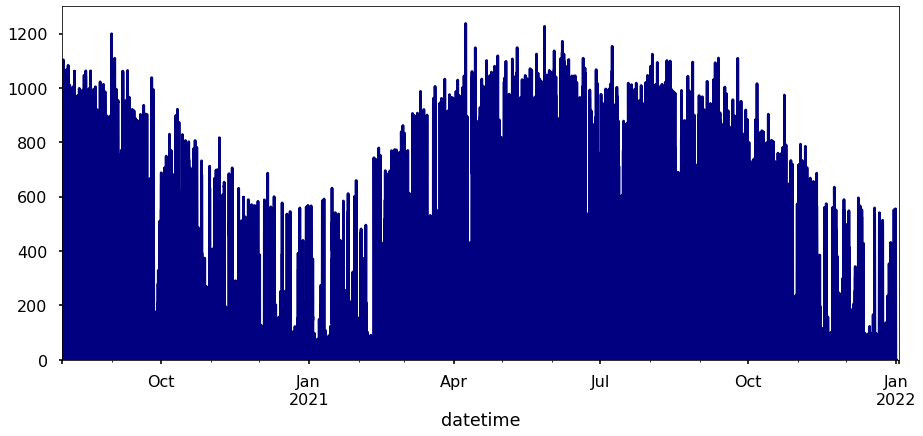

In [91]:
total_irrads.poa_global.plot()
plt.ylim(0,1300)

## Sandia Array Performance Model for temperature modelling

In [116]:
Sandia_Module_Temp_data = data[["AirTemp", "ws"]]
Sandia_Module_Temp_data

,AirTemp,ws
datetime,,
2020-08-01 00:00:00+00:00,23.492,2.298
2020-08-01 00:15:00+00:00,23.027,2.226
2020-08-01 00:30:00+00:00,22.518,2.416
2020-08-01 00:45:00+00:00,22.145,2.792
2020-08-01 01:00:00+00:00,21.883,2.694
...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN


In [117]:
Sandia_Temp_Model = pvlib.temperature.sapm_module(poa_global = total_irrads.poa_global, temp_air = data.AirTemp, wind_speed = data.ws, a = -3.47 , b = -0.0594)
Sandia_Temp_Model

datetime
2020-08-01 00:00:00+00:00    23.469764
2020-08-01 00:15:00+00:00    23.003249
2020-08-01 00:30:00+00:00    22.494773
2020-08-01 00:45:00+00:00    22.121608
2020-08-01 01:00:00+00:00    21.859155
                               ...    
2022-01-02 20:45:00+00:00          NaN
2022-01-02 21:00:00+00:00          NaN
2022-01-02 21:15:00+00:00          NaN
2022-01-02 21:30:00+00:00          NaN
2022-01-02 21:45:00+00:00          NaN
Length: 49912, dtype: float64

<AxesSubplot:xlabel='datetime'>

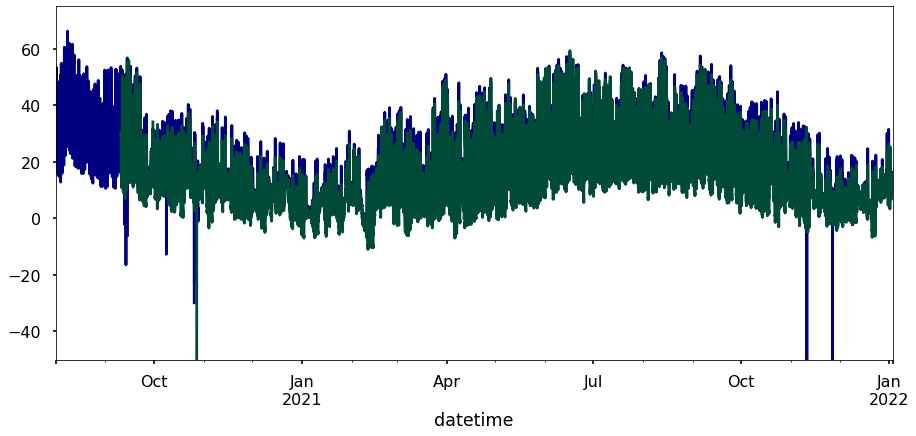

In [118]:
#Sandia Array Performance Model
Sandia_Temp_Model.plot()
plt.ylim(-50,75)
data.loc[:]['Tp'].plot()

(-10.0, 10.0)

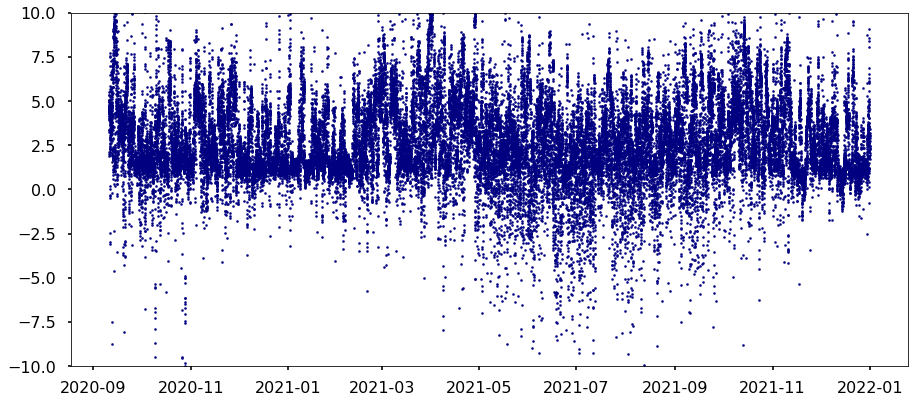

In [126]:
plt.scatter(data.loc[:]['Tp'].index, Sandia_Temp_Model - data.loc[:]['Tp'], s=4)
plt.ylim(-10,10)

## Power Modelling Using PVwatts model and modelled temp using the Sandia Array performance model as done above

In [120]:
# USing PVwatts model and modelled temp using the Sandia Array performance model as done above
Power_Model = pvlib.pvsystem.pvwatts_dc(data.POAc20, temp_cell= Sandia_Temp_Model, pdc0 = 310, gamma_pdc= -0.0037, temp_ref=25.0)
Power_Model

datetime
2020-08-01 00:00:00+00:00   -0.286207
2020-08-01 00:15:00+00:00   -0.307988
2020-08-01 00:30:00+00:00   -0.306608
2020-08-01 00:45:00+00:00   -0.311718
2020-08-01 01:00:00+00:00   -0.314740
                               ...   
2022-01-02 20:45:00+00:00         NaN
2022-01-02 21:00:00+00:00         NaN
2022-01-02 21:15:00+00:00         NaN
2022-01-02 21:30:00+00:00         NaN
2022-01-02 21:45:00+00:00         NaN
Length: 49912, dtype: float64

<AxesSubplot:xlabel='datetime'>

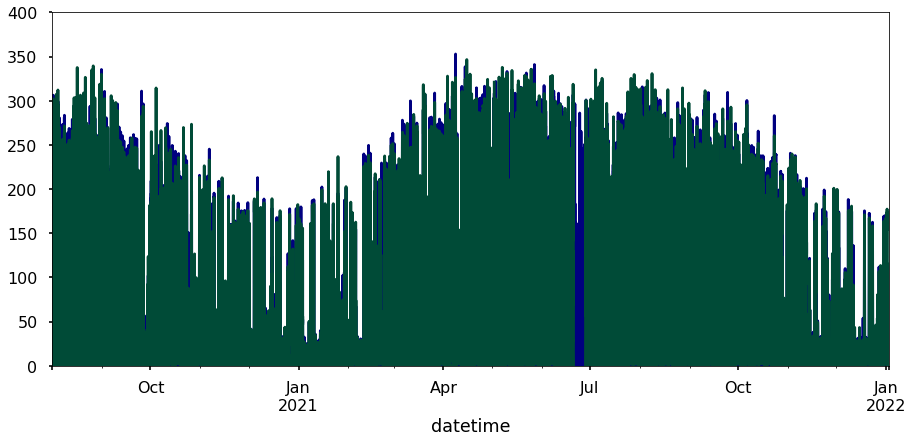

In [81]:
Power_Model.plot()
plt.ylim(0,400)
data.loc[:]['P31'].plot()

(-20.0, 30.0)

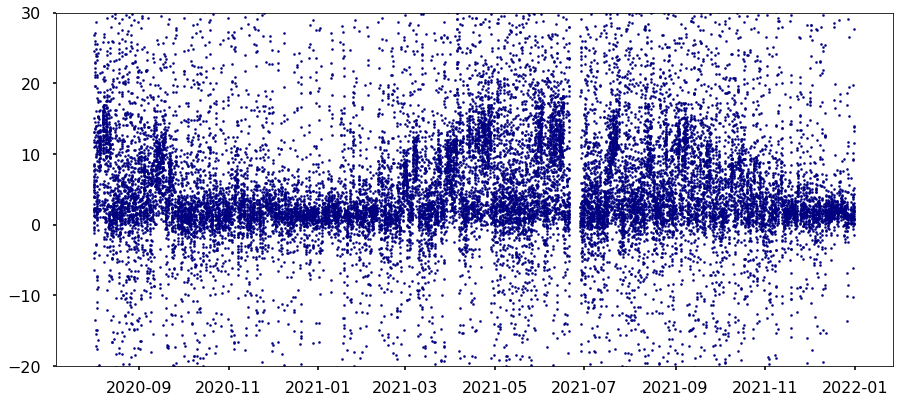

In [127]:
plt.scatter(data.loc[:]['P31'].index, Power_Model - data.loc[:]['P31'], s=4)
plt.ylim(-20,30)

## heat loss factor model for modelling temperature

In [83]:
HLS_Temp_Model_Data = data[["AirTemp", "ws"]]
HLS_Temp_Model_Data

,AirTemp,ws
datetime,,
2020-08-01 00:00:00+00:00,23.492,2.298
2020-08-01 00:15:00+00:00,23.027,2.226
2020-08-01 00:30:00+00:00,22.518,2.416
2020-08-01 00:45:00+00:00,22.145,2.792
2020-08-01 01:00:00+00:00,21.883,2.694
...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN


In [121]:
HLS_Temp_Model = pvlib.temperature.pvsyst_cell(poa_global = total_irrads.poa_global, temp_air = data.AirTemp, wind_speed = data.ws, u_c = 29.0, u_v = 0.0, eta_m = None, module_efficiency = 0.1, alpha_absorption=0.9)
HLS_Temp_Model

TypeError: pvsyst_cell() got an unexpected keyword argument 'module_efficiency'

##  the Fuentes model - Calculate cell or module temperature

In [96]:
Fuentes_Temp_Model_Data = data[["AirTemp", "ws"]] 
Fuentes_Temp_Model_Data

,AirTemp,ws
datetime,,
2020-08-01 00:00:00+00:00,23.492,2.298
2020-08-01 00:15:00+00:00,23.027,2.226
2020-08-01 00:30:00+00:00,22.518,2.416
2020-08-01 00:45:00+00:00,22.145,2.792
2020-08-01 01:00:00+00:00,21.883,2.694
...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN


In [98]:
Fuentes_Temp_Model = pvlib.temperature.fuentes(poa_global = total_irrads.poa_global, temp_air = data.AirTemp, wind_speed = data.ws, noct_installed = 45, module_height=5, wind_height=9.144, emissivity=0.84, absorption=0.83, surface_tilt=20, module_width=0.31579, module_length=1.2)
Fuentes_Temp_Model

AttributeError: module 'pvlib.temperature' has no attribute 'fuentes'

## Comparing Modelling temperature and Power Model for  P42 (tilt = 30) using the sandia array performance model for temperature and PV watts model for power using POA_global calculation also by model

In [122]:
# Calculating POA_Global for tilt angle = 30

In [123]:
Model_POA_data = data[["Diffuse_Solar_Flux", "Direct_Solar_Flux","SAA","SZA"]]
Model_POA_data

,Diffuse_Solar_Flux,Direct_Solar_Flux,SAA,SZA
datetime,,,,
2020-08-01 00:00:00+00:00,-1.077,-0.377,-177.411,90.0
2020-08-01 00:15:00+00:00,-1.173,-0.450,-173.536,90.0
2020-08-01 00:30:00+00:00,-1.173,-0.471,-169.682,90.0
2020-08-01 00:45:00+00:00,-1.170,-0.428,-165.862,90.0
2020-08-01 01:00:00+00:00,-1.173,-0.419,-162.088,90.0
...,...,...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN,NaN,NaN


In [124]:
air_mass = pvlib.atmosphere.get_relative_airmass(data.SZA, model='kasten1966')
tilt=30
ori = 2
doy = data.index.dayofyear

data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(data.SZA))

total_irrads_30=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=data.SZA,solar_azimuth=data.SAA,
                                         dni=data.Direct_Solar_Flux,
                                         ghi=data.Global_Solar_Flux,
                                         dhi=data.Diffuse_Solar_Flux,
                                         dni_extra=data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='klucher')
data['POAc30']=total_irrads_30.poa_global
total_irrads_30.poa_global

datetime
2020-08-01 00:00:00+00:00   -0.819115
2020-08-01 00:15:00+00:00   -0.871198
2020-08-01 00:30:00+00:00   -0.861614
2020-08-01 00:45:00+00:00   -0.887351
2020-08-01 01:00:00+00:00   -0.899281
                               ...   
2022-01-02 20:45:00+00:00         NaN
2022-01-02 21:00:00+00:00         NaN
2022-01-02 21:15:00+00:00         NaN
2022-01-02 21:30:00+00:00         NaN
2022-01-02 21:45:00+00:00         NaN
Name: poa_global, Length: 49912, dtype: float64

(0.0, 1300.0)

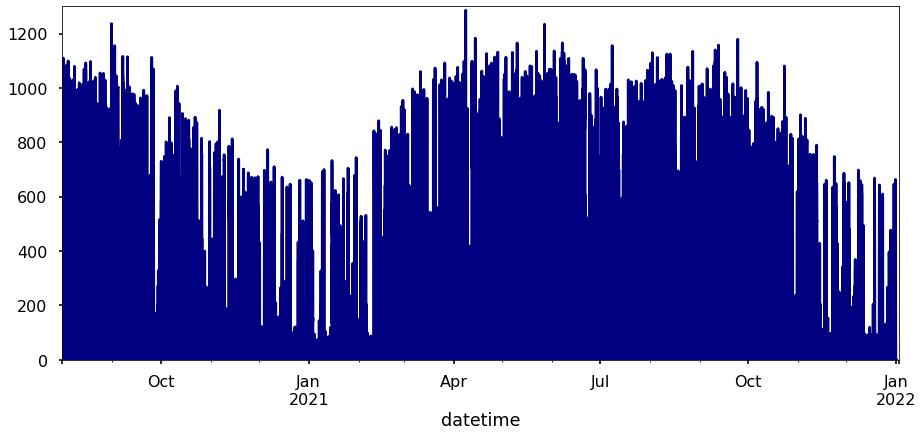

In [125]:
total_irrads_30.poa_global.plot()
plt.ylim(0,1300)

In [109]:
Model_Module_Temp_30_data = data[["AirTemp", "ws"]] #Sandia Array Performance Model
Model_Module_Temp_30_data

,AirTemp,ws
datetime,,
2020-08-01 00:00:00+00:00,23.492,2.298
2020-08-01 00:15:00+00:00,23.027,2.226
2020-08-01 00:30:00+00:00,22.518,2.416
2020-08-01 00:45:00+00:00,22.145,2.792
2020-08-01 01:00:00+00:00,21.883,2.694
...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN


In [110]:
# Sandia Array Performance Model
Temp_Model_30 = pvlib.temperature.sapm_module(poa_global = total_irrads_30.poa_global, temp_air = data.AirTemp, wind_speed = data.ws, a = -3.47 , b = -0.0594)
Temp_Model_30

datetime
2020-08-01 00:00:00+00:00    23.469764
2020-08-01 00:15:00+00:00    23.003249
2020-08-01 00:30:00+00:00    22.494773
2020-08-01 00:45:00+00:00    22.121608
2020-08-01 01:00:00+00:00    21.859155
                               ...    
2022-01-02 20:45:00+00:00          NaN
2022-01-02 21:00:00+00:00          NaN
2022-01-02 21:15:00+00:00          NaN
2022-01-02 21:30:00+00:00          NaN
2022-01-02 21:45:00+00:00          NaN
Length: 49912, dtype: float64

(-50.0, 75.0)

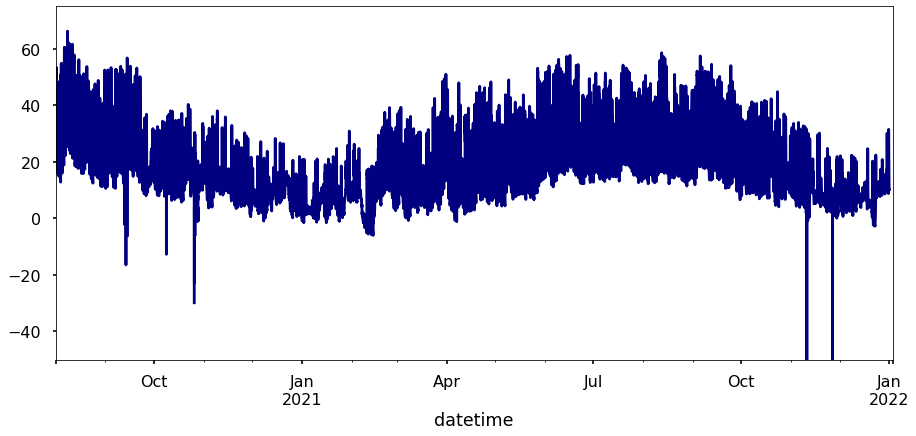

In [112]:
#Sandia Array Performace Model
Temp_Model_30.plot()
plt.ylim(-50,75)

In [113]:
Power_Model_30 = pvlib.pvsystem.pvwatts_dc(data.POAc30, temp_cell= Temp_Model_30, pdc0 = 310, gamma_pdc= -0.0037, temp_ref=25.0)
Power_Model_30

datetime
2020-08-01 00:00:00+00:00   -0.255363
2020-08-01 00:15:00+00:00   -0.272067
2020-08-01 00:30:00+00:00   -0.269576
2020-08-01 00:45:00+00:00   -0.278008
2020-08-01 01:00:00+00:00   -0.282017
                               ...   
2022-01-02 20:45:00+00:00         NaN
2022-01-02 21:00:00+00:00         NaN
2022-01-02 21:15:00+00:00         NaN
2022-01-02 21:30:00+00:00         NaN
2022-01-02 21:45:00+00:00         NaN
Length: 49912, dtype: float64

<AxesSubplot:xlabel='datetime'>

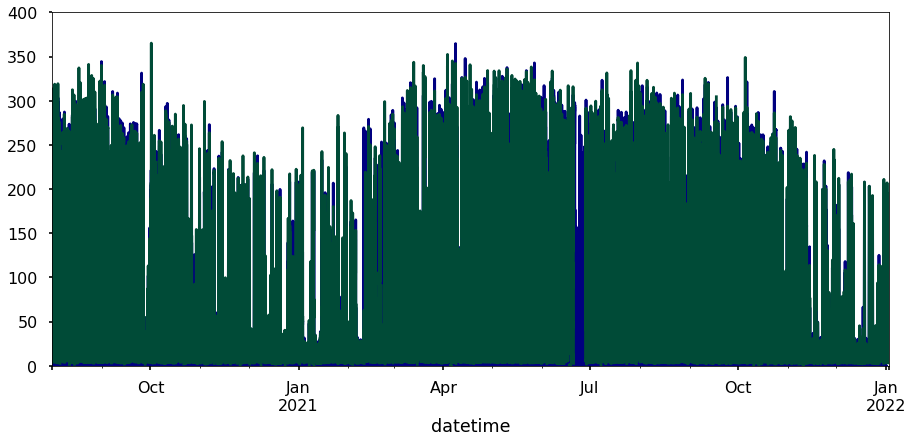

In [114]:
Power_Model_30.plot()
plt.ylim(0,400)
data.loc[:]['P42'].plot()

(-20.0, 30.0)

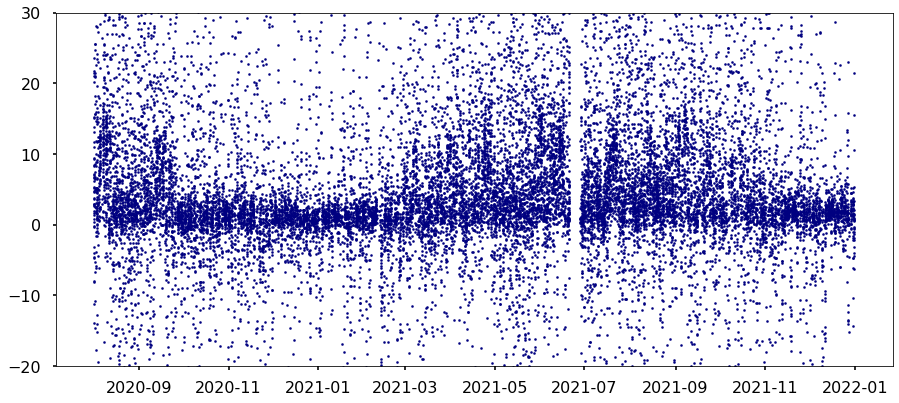

In [128]:
plt.scatter(data.loc[:]['P42'].index, Power_Model_30 - data.loc[:]['P42'], s=4)
plt.ylim(-20,30)